# Cell type annotation prediction

Run this notebook on google colab to use a free GPU!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Cell-Type-Annotation.ipynb)

In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
!pip install git+https://github.com/helicalAI/helical.git@main | tail -n 1

  Running command git clone --filter=blob:none --quiet https://github.com/helicalAI/helical.git /tmp/pip-req-build-m5_cmwkf
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.


In [2]:
!pip install tensorboard

In [3]:
!pip install datasets

In [8]:
!pip install datasets --upgrade

  Using cached datasets-2.20.0-py3-none-any.whl (547 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached pyarrow-17.0.0-cp39-cp39-macosx_11_0_arm64.whl (27.2 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.7
    Uninstalling datasets-2.14.7:
      Successfully uninstalled datasets-2.14.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.16.2 requires tensorflow==2.16.2; platform_system == "Darwin" and platform_machine == "arm64", but you have tensorflow 2.17.0 which is i

In [3]:
# %load_ext tensorboard # uncomment to use tensorboard

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
import os
import requests
import anndata as ad
import scanpy as sc
import torch

Define a function to download a trainig set: `c_data.h5ad` and an evaluation set: `ms_default.h5ad`.
We try and replicate the results of this [paper](https://www.biorxiv.org/content/10.1101/2023.10.24.563625v1) where the scGPT was compared to the Geneformer. The evaluation set was retrieved from their [Google Drive](https://drive.google.com/drive/folders/1bNOrB0ukkAuGtcocdvctSVOaAUG6uJ8l) and the training set from scGPT [here](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v).

In [2]:
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/maximeallard/helical/git/helical/helical/models/scgpt/model_dir/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [21]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True,num_proc=4,download_mode="reuse_cache_if_exists")
ds = ds.with_format("np")

Setting num_proc from 4 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split:   0%|          | 0/31680 [00:00<?, ? examples/s]

In [22]:
ds['train'].info

DatasetInfo(description='\nTest\n', citation='\nTest\n', homepage='https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-11673', license='', features={'raw_counts': Sequence(feature=Value(dtype='int32', id=None), length=-1, id='a1bg,a1bg-as1,a1cf,a2m,a2m-as1,a2ml1,a2ml1-as1,a3galt2,a4galt,a4gnt,aaas,aacs,aadac,aadacl2-as1,aadat,aaed1,aagab,aak1,aamdc,aamp,aanat,aar2,aard,aars,aars1,aars2,aarsd1,aasdh,aasdhppt,aass,aatbc,aatf,aatk,aatk-as1,ab015752.1,ab015752.3,abalon,abat,abc11-4932300o16.1,abc12-49244600f4.4,abc7-42404400c24.1,abca1,abca10,abca12,abca13,abca2,abca3,abca4,abca5,abca6,abca7,abca8,abca9,abca9-as1,abcb1,abcb10,abcb11,abcb4,abcb5,abcb6,abcb7,abcb8,abcb9,abcc1,abcc10,abcc11,abcc12,abcc2,abcc3,abcc4,abcc5,abcc5-as1,abcc6,abcc8,abcc9,abcd1,abcd2,abcd3,abcd4,abce1,abcf1,abcf2,abcf2.1,abcf3,abcg1,abcg2,abcg4,abcg5,abcg8,abhd1,abhd10,abhd11,abhd11-as1,abhd12,abhd12b,abhd13,abhd14a,abhd14a-acy1,abhd14b,abhd15,abhd15-as1,abhd16a,abhd16b,abhd17a,abhd17b,abhd17c,abhd18,abhd2,

In [30]:
observation_columns = [obs for obs in list(ds['train'].features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds['train'].select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
adata = ad.AnnData(ds['train']['raw_counts'],obs=obs_data)
adata.var_names = ds['train'].features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names

/Users/maximeallard/miniforge3/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Let's familiarise ourselves with the data!

We are interested in the names of the cells we want to predict. They are saved in `adata.obs["celltype"]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [32]:
adata.var['gene_name'] = adata.var_names.str.upper()

In [24]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

This is all summarized in this dictionary:

In [25]:
id2type

{0: 'ERYTHROID',
 1: 'LYMPHOID',
 2: 'MK',
 3: 'MYELOID',
 4: 'PROGENITOR',
 5: 'STROMA'}

Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x` for our smaller NN model.

# scGPT

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(adata, gene_names = "gene_name")
x_scgpt = scgpt.get_embeddings(data)
x_scgpt.shape

INFO:helical.services.downloader:File: '/Users/maximeallard/.cache/helical/models/scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/Users/maximeallard/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
INFO:helical.services.downloader:File: '/Users/maximeallard/.cache/helical/models/scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.services.downloader:File saved to: '/Users/maximeallard/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
/Users/maximeallard/miniforge3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabl

KeyboardInterrupt: 

Let's do the same with the Geneformer. It needs a few adjustments to the column names and needs the number of counts per observation.

With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we one-hot-encode the 18 different cell type labels.

In [18]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)
y_encoded.shape

(7844, 18)

## Define and train the model

In [9]:
input_shape = (512,)

# define the model
head_model = Sequential()
head_model.add(Dense(128, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4))
head_model.add(Dense(32, activation='relu'))
head_model.add(Dropout(0.4))
head_model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
head_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
head_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 18)                594       
                                                                 
Total params: 70386 (274.95 KB)
Trainable params: 70386 (274.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
head_model_scgpt = head_model
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_scgpt.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
111/111 [==============================] - 1s 8ms/step - loss: 2.2411 - f1_score: 0.1084 - val_loss: 1.4518 - val_f1_score: 0.1727
Epoch 2/50
111/111 [==============================] - 1s 6ms/step - loss: 1.4921 - f1_score: 0.2125 - val_loss: 1.2573 - val_f1_score: 0.2666
Epoch 3/50
111/111 [==============================] - 1s 5ms/step - loss: 1.3320 - f1_score: 0.2730 - val_loss: 1.1184 - val_f1_score: 0.2998
Epoch 4/50
111/111 [==============================] - 1s 5ms/step - loss: 1.1970 - f1_score: 0.3253 - val_loss: 0.9917 - val_f1_score: 0.3936
Epoch 5/50
111/111 [==============================] - 1s 5ms/step - loss: 1.1259 - f1_score: 0.3526 - val_loss: 0.9038 - val_f1_score: 0.4356
Epoch 6/50
111/111 [==============================] - 1s 5ms/step - loss: 1.0379 - f1_score: 0.3883 - val_loss: 0.8378 - val_f1_score: 0.4972
Epoch 7/50
111/111 [==============================] - 1s 5ms/step - loss: 0.9897 - f1_score: 0.4275 - val_loss: 0.7936 - val_f1_score: 0.4969
Epoch 

In [20]:
predictions_nn = head_model_scgpt.predict(X_test)
y_pred = np.argmax(predictions_nn, axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 0s 2ms/step


## Present the results
- on the test set and,
- a separate, unseen evaluation set

In [14]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [21]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 84.5%
Test set precision: 75.0%
Test set f1: 72.8%
Test set recall: 72.0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8445859872611465,
 'precision': 0.7497929077554761,
 'f1': 0.7281361087602812,
 'recall': 0.7197921828495202}

Load the unseen evaluation set:

In [22]:
adata_unseen = sc.read("ms_default.h5ad")
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = head_model_scgpt.predict(x_unseen)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Embedding cells: 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


246/246 [==============================] - 0s 1ms/step


We should double check that the cell types are mapped to the correct id numbers for both the training data (`c_data.h5ad`) and this new data set (`ms_default.h5a`).

In [23]:
num_types = adata_unseen.obs["celltype"].unique().shape[0]
id2type_unseen = dict(enumerate(adata_unseen.obs["celltype"].astype("category").cat.categories))
id2type_unseen == id2type

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [24]:
y_true_unseen = np.array(adata_unseen.obs["celltype"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen, axis=1)]

scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 86.8%
Evaluation set precision: 68.5%
Evaluation set f1: 68.3%
Evaluation set recall: 68.5%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plot a confusion matrix to visualise the classification performance for each the cell type. This is done for the evalation set.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


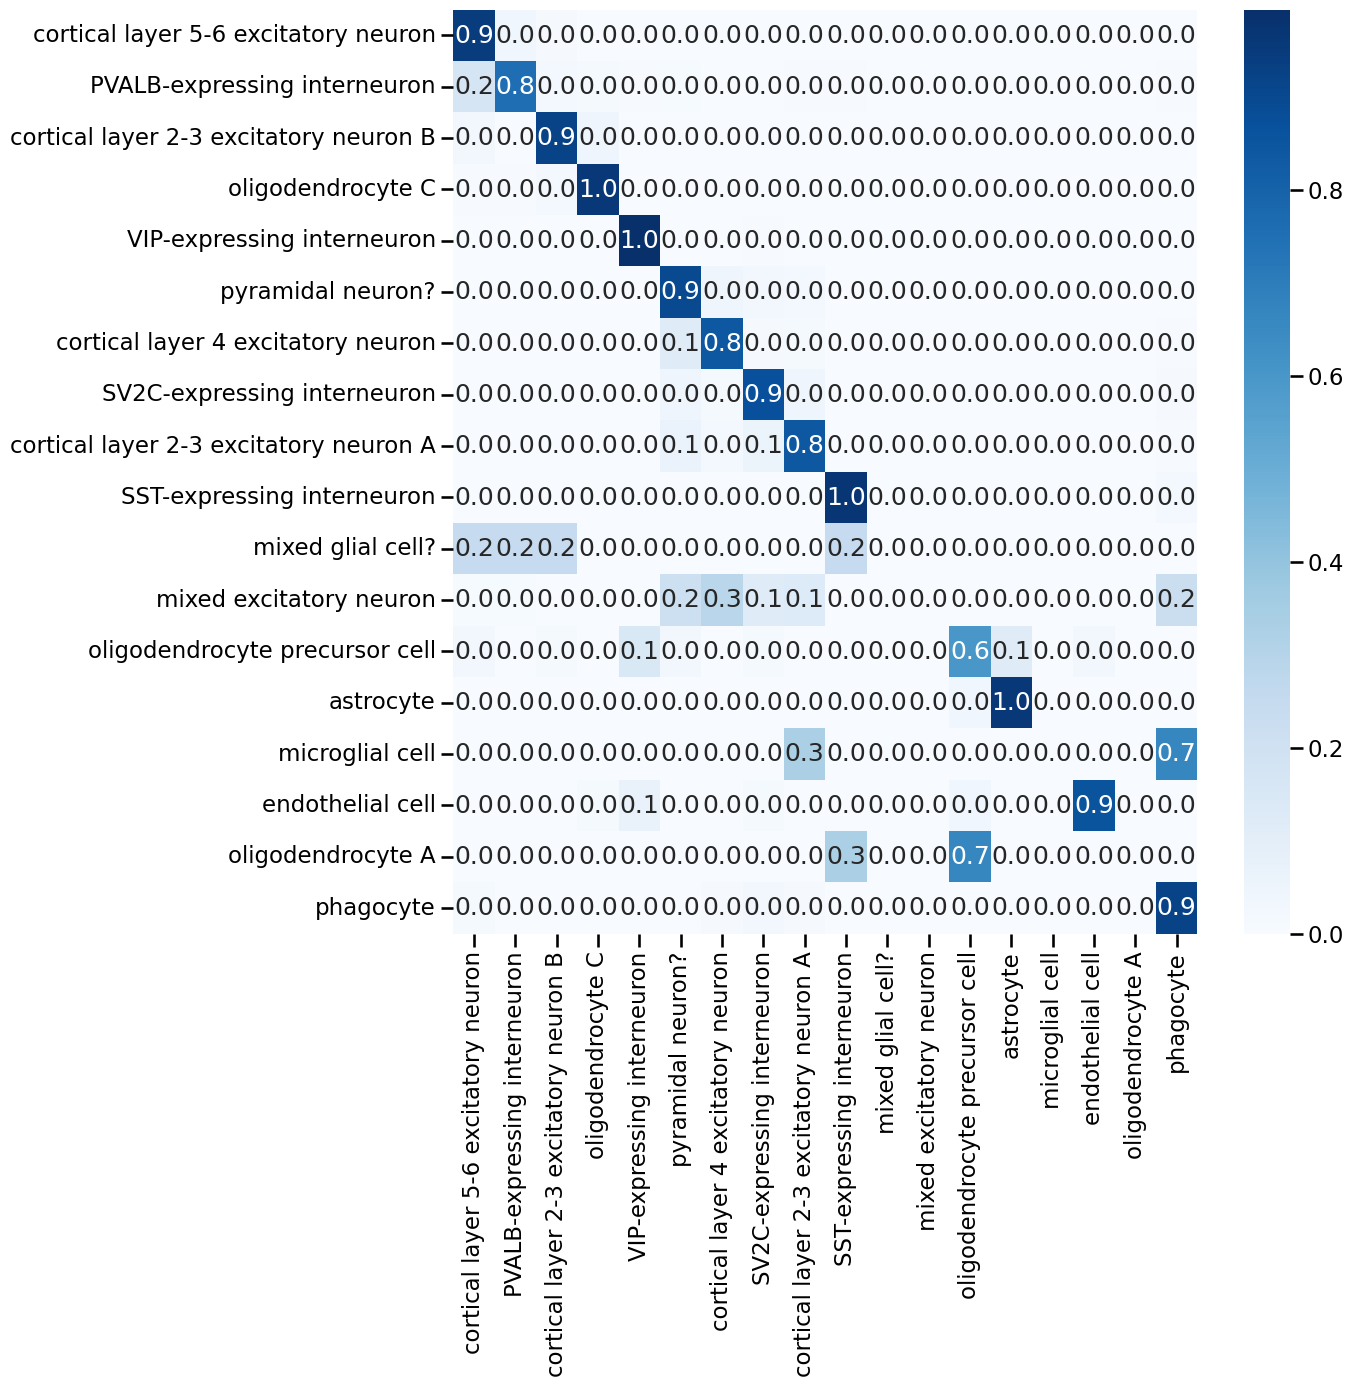

In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

set_predicted_cell_types = list(adata_unseen.obs["celltype"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)

cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

# Geneformer

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
adata.obs['cell_type'] = adata.obs['celltype']
adata.var["ensembl_id"] = adata.var["index_column"]

geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata, gene_names = "ensembl_id")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/helical/models/geneformer/geneformer_tokenizer.py:365: DeprecationWarning: Calling nonzero on 0

Map:   0%|          | 0/7844 [00:00<?, ? examples/s]

  0%|          | 0/157 [00:00<?, ?it/s]

(7844, 512)

In [10]:
head_model_geneformer = head_model
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_geneformer.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Epoch 1/50
111/111 [==============================] - 4s 8ms/step - loss: 2.4078 - f1_score: 0.0563 - val_loss: 2.0720 - val_f1_score: 0.0467
Epoch 2/50
111/111 [==============================] - 1s 5ms/step - loss: 2.1475 - f1_score: 0.0598 - val_loss: 1.9686 - val_f1_score: 0.0592
Epoch 3/50
111/111 [==============================] - 1s 5ms/step - loss: 2.0249 - f1_score: 0.0854 - val_loss: 1.8295 - val_f1_score: 0.0999
Epoch 4/50
111/111 [==============================] - 1s 5ms/step - loss: 1.9092 - f1_score: 0.1185 - val_loss: 1.7238 - val_f1_score: 0.1624
Epoch 5/50
111/111 [==============================] - 1s 6ms/step - loss: 1.8041 - f1_score: 0.1437 - val_loss: 1.6246 - val_f1_score: 0.1736
Epoch 6/50
111/111 [==============================] - 1s 6ms/step - loss: 1.7270 - f1_score: 0.1578 - val_loss: 1.5454 - val_f1_score: 0.1854
Epoch 7/50
111/111 [==============================] - 1s 7ms/step - loss: 1.6607 - f1_score: 0.1639 - val_loss: 1.4947 - val_f1_score: 0.2048
Epoch 

In [ ]:
# %tensorboard --logdir logs/fit # uncomment to use tensorboard

In [12]:
adata_unseen = sc.read("ms_default.h5ad")
adata_unseen.var["ensembl_id"] = adata_unseen.var["index_column"]
adata_unseen.obs['cell_type'] = adata_unseen.obs['celltype']
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "ensembl_id")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer.predict(x_unseen_geneformer)

/usr/local/lib/python3.10/dist-packages/helical/models/geneformer/geneformer_tokenizer.py:365: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  filter_pass_loc = np.where(adata.obs.get("filter_pass", 0) == 1)[0]


Map:   0%|          | 0/7844 [00:00<?, ? examples/s]

  0%|          | 0/157 [00:00<?, ?it/s]

246/246 [==============================] - 1s 2ms/step


In [15]:
y_true_unseen = np.array(adata_unseen.obs["celltype"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen_geneformer, axis=1)]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 64.1%
Evaluation set precision: 59.2%
Evaluation set f1: 49.7%
Evaluation set recall: 51.2%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


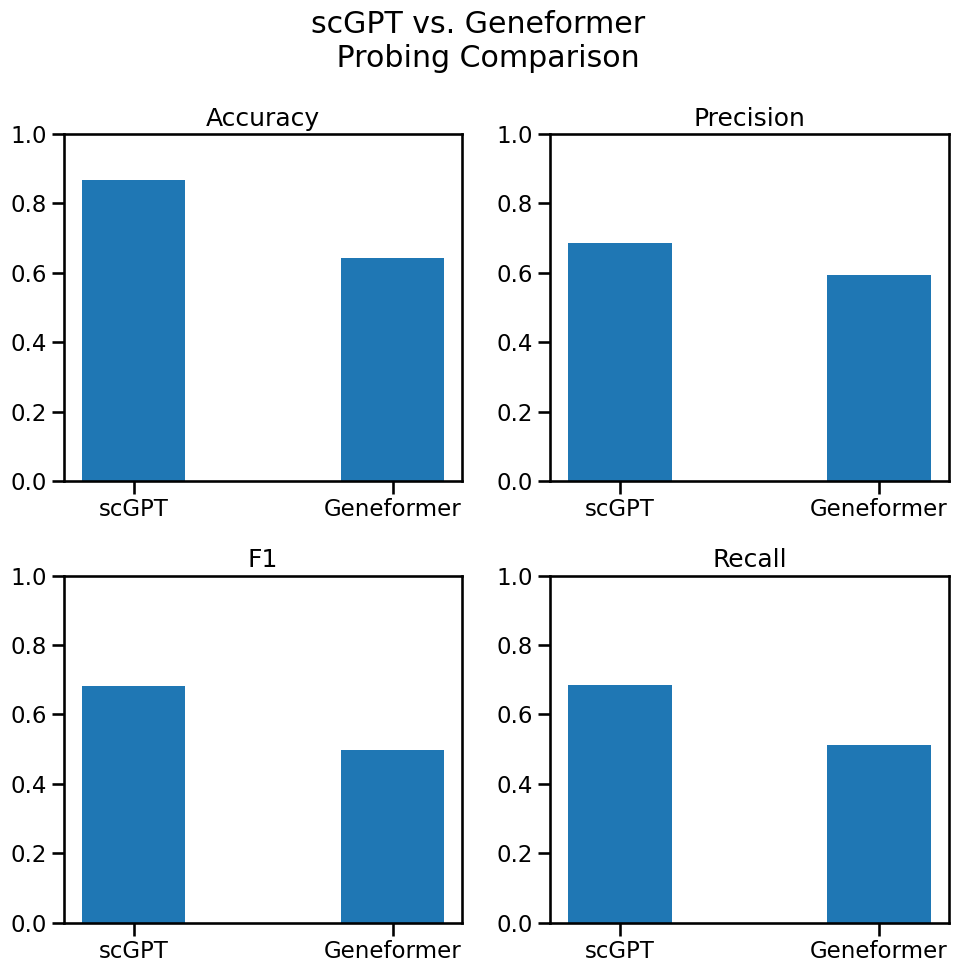

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()


We can see that the Geneformer clearly underperforms in all metrics. scGPT has similar results to what is reported in the [paper](https://www.biorxiv.org/content/10.1101/2023.10.24.563625v1.full.pdf). Keeping in mind, of course, that in that paer, the entire models were fine tuned.

## scGPT
- Accuracy: 86.4%
- Precision: 81.1%
- Recall: 76.4%
- Macro F1: 75.3%

## Geneformer
- Accuracy: 73.1%
- Precision: 55.0%
- Recall: 58.7%
- Macro F1: 56.0%